In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.536445  1.059634  0.039750 -0.621788  0.261034  0.551030  0.151743   
  1  -1.174322  0.386750  0.454552  0.390511  0.137501  0.338335 -0.328924   
  2   0.434034  0.113963  0.135665  0.272032  0.234789  0.151726 -0.543205   
  3   0.376482 -0.020337  0.105457 -0.097289 -1.340543 -0.183061 -0.358352   
  4  -0.332687 -1.454900 -0.563699  0.583702  0.120813 -0.198430 -0.656226   
  5  -0.604033 -0.738204 -0.565840 -0.366383  0.151370 -0.760647  0.490164   
  6   0.195428  0.057370 -0.580333 -0.292302 -0.083272 -0.038344  0.572838   
  7   0.164027  0.041795  0.032145 -0.645004  1.384083  0.243093 -0.033583   
  8   0.359848 -0.498073 -0.808142 -0.654769 -0.859348 -0.560605 -0.655534   
  9  -0.942843 -0.414534  0.073406 -0.578350  0.169923 -0.773922 -0.635668   
  10 -0.038777  0.975580  0.267465  0.211111 -0.729200  0.337118 -0.671800   
  11  1.009140  0.358034 -0.225157  0.903134  0.904177 -0.118106 -0.828305   
  12 -0.880442 -0.544153 -0.336502 -1.187624 -1.189881  0.731257 -0.753793   
  13  0.217321  0.459926 -0.058733 -0.089538  0.312034  0.060728 -1.015484   
  14 -0.756374 -0.180514 -0.710076 -0.981621 -0.535160  0.265926 -0.721157   
  15  0.102554  0.746354 -0.121715  0.826112  1.182943  0.045421 -0.006338   
  16 -0.155882 -0.344738  0.346659  0.950103  0.225726 -0.830608 -0.962407   
  17  0.013322 -0.020327  0.461975 -0.687792 -0.310325 -1.837767 -1.157939   
  18  0.422358  0.463736 -0.531456  0.020360  0.704183  0.258697  0.107928   
  19  0.389157  0.600531  0.491204 -0.043488  0.816724  0.102213 -0.049381   
  20 -0.770768  0.207569  0.415444 -0.407528 -0.242263  0.101114 -0.608359   
  21 -0.118882 -0.849539 -0.004116  0.222392 -0.394138 -1.257069 -0.431303   
  22 -0.074108 -0.374448 -0.084517  0.058600 -0.139825  0.025330 -0.117453   
  23  0.418723  0.214862 -0.531105 -0.482614 -0.440879 -0.144162  0.092627   
  24 -0.350104 -0.692901 -0.329751  0.072672 -0.184829 -0.316180 -0.621949   
1 0  -0.960451  0.010121  0.222525 -0.446551 -0.020429 -0.502189 -0.064545   
  1  -0.467410 -0.352936 -0.456667 -0.533136  0.488609  0.741376  0.085416   
  2  -0.786662 -0.330991 -0.559220 -1.092086 -0.964501 -1.204193 -0.544896   
  3   0.352438  0.153984 -1.965477 -1.437699 -0.975546  0.861944  0.504961   
  4  -0.270457 -0.830350 -0.170923 -1.183265 -0.400884 -0.236608 -0.087550   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.285385  0.100671  0.065948  ...  0.458096  0.074127 -0.216920   
  1  -0.001996  0.261646  0.532137  ...  1.166989 -0.112093 -0.065018   
  2  -0.652620  0.646472  0.183722  ...  0.894755  0.218479  0.385925   
  3   0.263245  0.411663  0.673450  ...  0.131472  0.567060  1.586021   
  4  -1.136217  0.447471 -0.090156  ... -0.106797 -0.698582 -0.674536   
  5  -0.897202  0.123009 -0.055784  ...  0.265097  0.104425 -0.348460   
  6   0.053452  0.605309  1.018965  ...  0.173623 -0.039245  0.545307   
  7  -0.493500  0.206870  0.212197  ...  0.074316  0.574282 -0.354027   
  8   1.688164  1.279195  0.675795  ...  0.882691 -0.636559 -0.210435   
  9  -0.101111  0.511853 -0.684970  ... -0.100511 -0.626219 -0.825502   
  10 -0.202621  0.395849 -0.995354  ...  0.543522  0.196548  0.158745   
  11 -0.122872  0.508579 -0.183774  ... -0.077347  0.465980 -0.301132   
  12  0.451101  0.265281  0.042385  ...  0.230549 -0.901634 -0.820238   
  13 -0.135622  0.120982  1.276317  ...  0.147546  0.691615 -0.360004   
  14 -0.560054  0.513535 -0.003153  ...  1.169337  0.685313 -0.181818   
  15  0.568062  0.096435  0.619085  ...  0.365130  0.441599 -0.043247   
  16 -0.110060  0.102124  0.731514  ...  0.708324  0.519193  0.125863   
  17 -0.468155  0.104233 -0.252993  ...  1.118772  0.370766  0.893751   
  18 -0.057508  0.561419 -0.190218  ...  0.173702 -0.113498  0.785208   
  19  0.006375  0.293325  1.047121  ...  0.956207 -1.635120 -0.566658   
  20  1.006354  0.857477  0.086936  ... -0.174832 -0.379845 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.077512  0.043776  24.613954  8.955623e-134  0.991711  1.163312


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



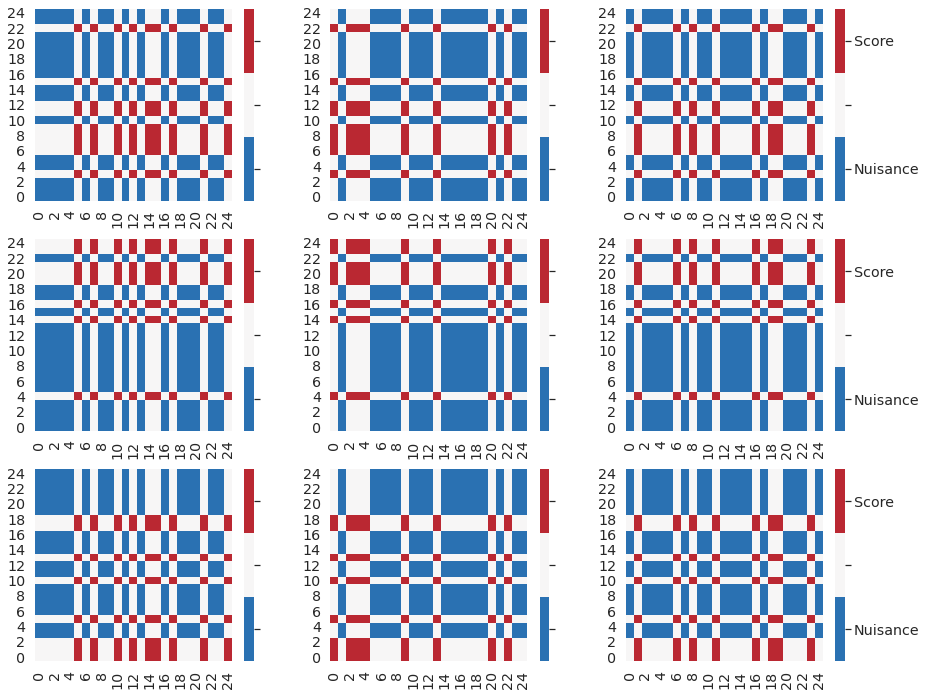

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



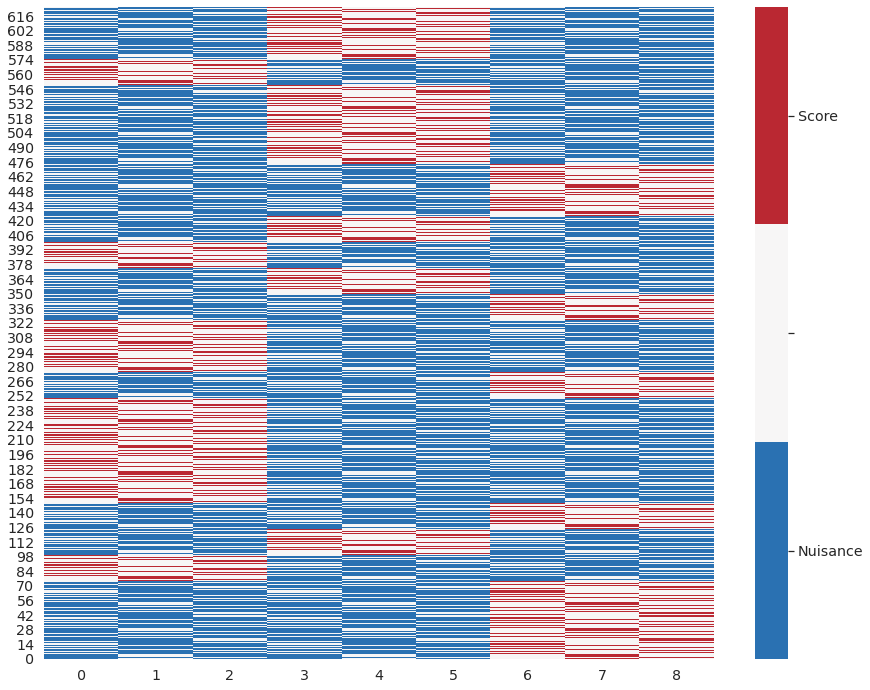

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])